In [55]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.utils import shuffle

## 3-1 SVC et SMO

### Principe

Le principe des SVC est de séparer l'espace en deux sous-espaces, celui des échantillons négatifs, et celui des positifs, en aillant la séparation la plus grande possible. Les SVC sont donc assimilés à un problème d'optimisation.

On pose $\vec w$ le vecteur normal à notre hyperplan qui sépare nos échantillons positifs et négatifs. On ne connait pas encore sa longueur. On a aussi un point que l'on veut classifier, représenté par le vecteur $\vec u$. On le projette donc sur $\vec w$, ce qui revient donc à voir notre classification positive comme:

$$
\vec w \cdot \vec u \geqslant C
\iff \vec w \cdot \vec u + b \geqslant 0
$$

avec $C$ et $b$ des constantes.

On pose à nouveau plusieurs contraintes:

$$
\vec w \cdot \vec x_{+} + b \geqslant 1
$$
$$
\vec w \cdot \vec x_{-} + b \leqslant -1
$$

ou $\vec x_{+}$ correspond à un échantillon positif et $\vec x_{-}$ à un négatif.

On introduit $y_{i}$ tel que $y_{i} = 1$ pour un échantillon positif et $y_{i} = -1$ pour un échantillon négatif. En multipliant les équations précédentes par $y_{i}$, on obtient:

$$
y_{i}(\vec w \cdot \vec x_{i} + b) \geqslant 1
$$
$$
\iff y_{i}(\vec w \cdot \vec x_{i} + b) -1 \geqslant 0
$$

Et l'on peut dire des échantillons qui tombent dans la séparation, que:

$$
y_{i}(\vec w \cdot \vec x_{i} + b) -1 = 0
$$

Pour obtenir la largeur de la séparation, il suffit de soustraire un échantillon négatif à un positif et de le multiplier par un vecteur unitair normal à notre hyperplan, comme suit:

$$
width = (\vec x_{+} - \vec x_{-})  \cdot \frac{\vec w}{||\vec w||} = \frac{2}{||\vec w||}
$$

Puisqu'on cherche à avoir la plus grande séparation inter-classe, on cherche donc à maximiser $\frac{2}{||\vec w||}$, ce qui revient à chercher à minimiser $||\vec w||$, ou, pour plus de convénience mathématique, à minimiser $\frac{1}{2}||\vec w||^2$ sujet à $y_{i}(\vec w \cdot \vec x_{i} + b) -1 \geqslant 0$.

En passant par le Lagrangien, on obtient:

$$L = \frac{1}{2}||\vec w||^2 - \sum \alpha_{i} [y_{i}(\vec w \cdot \vec x_{i} + b) - 1]$$

ou $\alpha_{i}$ sont les coefficient multiplicateur du Langrangien. On dérive partiellement par $\vec w$ et $b$.

$$\frac{\partial{L}}{\partial{w}} = 0 \iff \vec w - \sum \alpha_{i} y_{i} \vec x_{i} = 0$$
$$\iff \vec w = \sum \alpha_{i} y_{i} \vec x_{i}$$
$$\frac{\partial{L}}{\partial{b}} = 0 \iff - \sum \alpha_{i} y_{i}= 0$$
$$\iff b = \sum \alpha_{i} y_{i}$$

C'est grâce à ces égalités qu'on va, entre autre, pouvoir implémenter la SMO, ou Sequential Minimal Optimization.

### Implémentation de la SMO

### Principe

La SMO est un algorithme qui permet de résoudre rapidement des problèmes d'optimisation de type SVC QP (quadratic programming) de manière analytique. Cet algorithme se base sur le théorème de Osuna qui assure la convergence en cas de subdivision de problèmes QP en sous problèmes QP.

A chaque étape, on choisit de résoudre le problème d'optimisation le plus petit possible. Celui-ci implique deux coefficients multiplicateurs de Lagrange, $\alpha_{1}$ et $\alpha_{2}$. A chaque étape, ils sont optimisés conjointement pendant que tous les autres coefficients sont conservés identiques, et ainsi de suite jusqu'à convergence. Le choix des coefficients est fait à chaque étape grâce à une heuristique, le but étant de choisir au moins un coefficient ne respectant pas les condition du KKT. Si au moins un des deux coefficients utilisé respecte cette condition, alors le problème est garantit de diminuer, via le théorème de Osuna.

L'implémentation suivante est une version simplifiée de la SMO, avec un choix de coefficients aléatoire.

_[sources: http://cs229.stanford.edu/materials/smo.pdf et https://www.microsoft.com/en-us/research/publication/sequential-minimal-optimization-a-fast-algorithm-for-training-support-vector-machines/]_

In [391]:
class SMO:
    def __init__(self, kernel=None, max_iter=10000, epsilon=0.001, C=1.0):
        if (kernel == None):
            self.kernel = lambda x1, x2 : np.dot(x1, x2.T)
        else:
            self.kernel = kernel
        self.epsilon = epsilon
        self.C = C
        self.max_iter = max_iter
        self.b = None
        self.w = None
    
    '''
    the function that predict the class of an sample thanks to the normal vector w and b
    '''
    def h(self, X):
        return np.sign(np.dot(self.w, X.T) - self.b).astype(int)
    
    '''
    the function that computes the w vector thanks to Lagrange multipliers alpha
    '''
    def compute_w(self, alphas, X, y):
        w = 0
        for i in range(X.shape[0]):
            w += alphas[i] * y[i] * X[i,:]
        self.w = w
    
    def randexclusif(self, mn, mx, excl):
        res = random.randint(mn, mx)
        while (res == excl):
            res = random.randint(mn, mx)
        return res
    
    def fit(self, X, y):
        self.b = 0
        size = (X.shape[0])
        alphas = np.zeros((size))
        for count in range(self.max_iter):
            prev_alphas = np.copy(alphas)
            for i in range(size):
                y1 = y[i]
                x1 = X[i, :]
                alpha1 = alphas[i]
                
                self.compute_w(alphas, X, y)
                Ei = self.h(x1) - y1
                if ((Ei*y1 < -self.epsilon and alpha1 < self.C) or (Ei*y1 > self.epsilon and alpha1 > 0)):
                    #selection of j != i for a simplified SMO method
                    j = self.randexclusif(0, size - 1, i)
                    y2 = y[j]
                    x2 = X[j, :]
                    alpha2 = alphas[j]
                    
                    Ej = self.h(x2) - y2
                    
                    if (y1 == y2):
                        L = max(0, alpha2 + alpha1 - self.C)
                        H = min(self.C, alpha2 + alpha1)
                    else:
                        L = max(0, alpha2 - alpha1)
                        H = min(self.C, self.C + alpha2 - alpha1)
                    
                    if (L == H):
                        continue
                    
                    nu = self.kernel(x1, x1) + self.kernel(x2, x2) - 2 * self.kernel(x1, x2)
                    
                    if (nu < 0):
                        continue
                
                    a2 = alpha2 + float(y2 * (Ei - Ej)) / nu
                    if (a2 > H):
                        a2 = H
                    elif (a2 < L):
                        a2 = L
                    alphas[j] = a2
                    
                    if (abs(a2 - alpha2) < self.epsilon):
                        continue
                    
                    alphas[i] = alpha1 + y1 * y2 * (alpha2 - a2)
                    b1 = Ei + y1 * (alphas[i] - alpha1) * self.kernel(x1, x1) + y2 * (a2 - alpha2) * self.kernel(x1, x2) + self.b
                    b2 = Ej + y1 * (alphas[i] - alpha1) * self.kernel(x1, x2) + y2 * (a2 - alpha2) * self.kernel(x2, x2) + self.b
                    
                    if (alphas[i] > 0 and alphas[i] < self.C):
                        self.b = b1
                    elif (a2 > 0 and a2 < self.C):
                        self.b = b2
                    else:
                        self.b = (b1 + b2) / 2
            diff = np.linalg.norm(alphas - prev_alphas)
            if diff < self.epsilon:
                break
        self.compute_w(alphas, X, y)

    def predict(self, X):
        return self.h(X)

### Fonctions de comparaisons avec un SVC linéaire classique

In [407]:
def generate_problem(size, percent=0.2, linear=True):
    if (linear):
        separable = False
        while not separable:
            samples = make_classification(n_samples=size, n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1, flip_y=-1, weights=[0.5,0.5])
            red = samples[0][samples[1] == 0]
            blue = samples[0][samples[1] == 1]
            separable = any([red[:, k].max() < blue[:, k].min() or red[:, k].min() > blue[:, k].max() for k in range(2)])
    else:
        samples = make_classification(n_samples=size, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=2, flip_y=-1)
        red = samples[0][samples[1] == 0]
        blue = samples[0][samples[1] == 1]
    plt.plot(red[:, 0], red[:, 1], 'r.')
    plt.plot(blue[:, 0], blue[:, 1], 'b.')
    plt.show()
    red = np.array([np.append(red[i], -1) for i in range(len(red))])
    blue = np.array([np.append(blue[i], 1) for i in range(len(blue))])
    perc = int(percent * size)
    trainr = red[:perc]
    testr = red[perc:]
    trainb = blue[:perc]
    testb = blue[perc:]
    res = np.append(trainr, trainb, axis=0)
    res = shuffle(res)
    res2 = np.append(testr, testb, axis=0)
    res2 = shuffle(res)
    X = res[:,:2]
    y = res[:,-1]
    Xtest = res2[:,:2]
    ytest = res2[:,-1]
    return X, y, Xtest, ytest

In [370]:
from sklearn.metrics import f1_score

def compareSVC_SMO(linear=True):
    X, y, Xtest, ytest = generate_problem(1000, 0.2, linear)
    Xall = np.append(X, Xtest, axis=0)
    yall = np.append(y, ytest, axis=0)
    minX = min(Xall[:,0])
    maxX = max(Xall[:,0])
    minX *= 1.2
    maxX *= 1.2
    model = SVC(kernel='linear', C = 1.0)
    model.fit(X, y)
    y_hat_svc = model.predict(X)
    y_hattest_svc = model.predict(Xtest)
    acc = f1_score(y, y_hat_svc)
    acc2 = f1_score(ytest, y_hattest_svc)
    print("accuracy train for SVC:\t%.3f" % (acc))
    print("accuracy test for SVC:\t%.3f" % (acc2))
    w = model.coef_[0]
    
    model2 = SMO()
    model2.fit(X, y)
    y_hat_smo = model2.predict(X)
    y_hattest_smo = model2.predict(Xtest)
    acc = f1_score(y, y_hat_smo)
    acc3 = f1_score(ytest, y_hattest_smo)
    print("accuracy train for SMO:\t%.3f" % (acc))
    print("accuracy test for SMO:\t%.3f" % (acc3))
    w = model2.w
    
    xx = np.linspace(minX,maxX)
    fig, axs = plt.subplots(2, figsize=(20,20))
    fig.suptitle('SVC vs SMO results', fontsize=20)
    
    yy = - 1 * (xx*w[0] + model.intercept_) / w[1]
    yy1 = - 1 * (xx*w[0] + model.intercept_ - 1) / w[1]
    yy2 = - 1 * (xx*w[0] + model.intercept_ + 1) / w[1]
    axs[0].plot(xx, yy, 'k--', label='hyperplan')
    axs[0].plot(xx, yy1, 'k-', label='margin')
    axs[0].plot(xx, yy2, 'k-', label='margin')
    axs[0].scatter(Xall[:, 0], Xall[:, 1], c = yall)
    axs[0].set_title('SVC, accuracy: ' + str(acc2), fontsize=16)
    axs[0].legend(loc='best', fontsize='large')
    
    yy3 = - 1 * (xx*w[0] + model2.b) / w[1]
    yy4 = - 1 * (xx*w[0] + model2.b - 1) / w[1]
    yy5 = - 1 * (xx*w[0] + model2.b + 1) / w[1]
    axs[1].plot(xx, yy3, 'k--', label='hyperplan')
    axs[1].plot(xx, yy4, 'k-', label='margin')
    axs[1].plot(xx, yy5, 'k-', label='margin')
    axs[1].scatter(Xall[:, 0], Xall[:, 1], c = yall)
    axs[1].set_title('SMO, accuracy: ' + str(acc3), fontsize=16)
    axs[1].legend(loc='best', fontsize='large')
    plt.show()

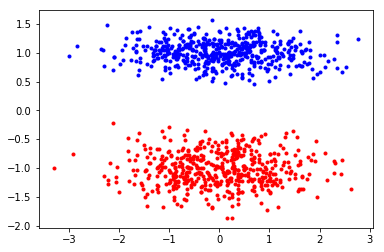

accuracy train for SVC:	1.000
accuracy test for SVC:	1.000
accuracy train for SMO:	1.000
accuracy test for SMO:	1.000


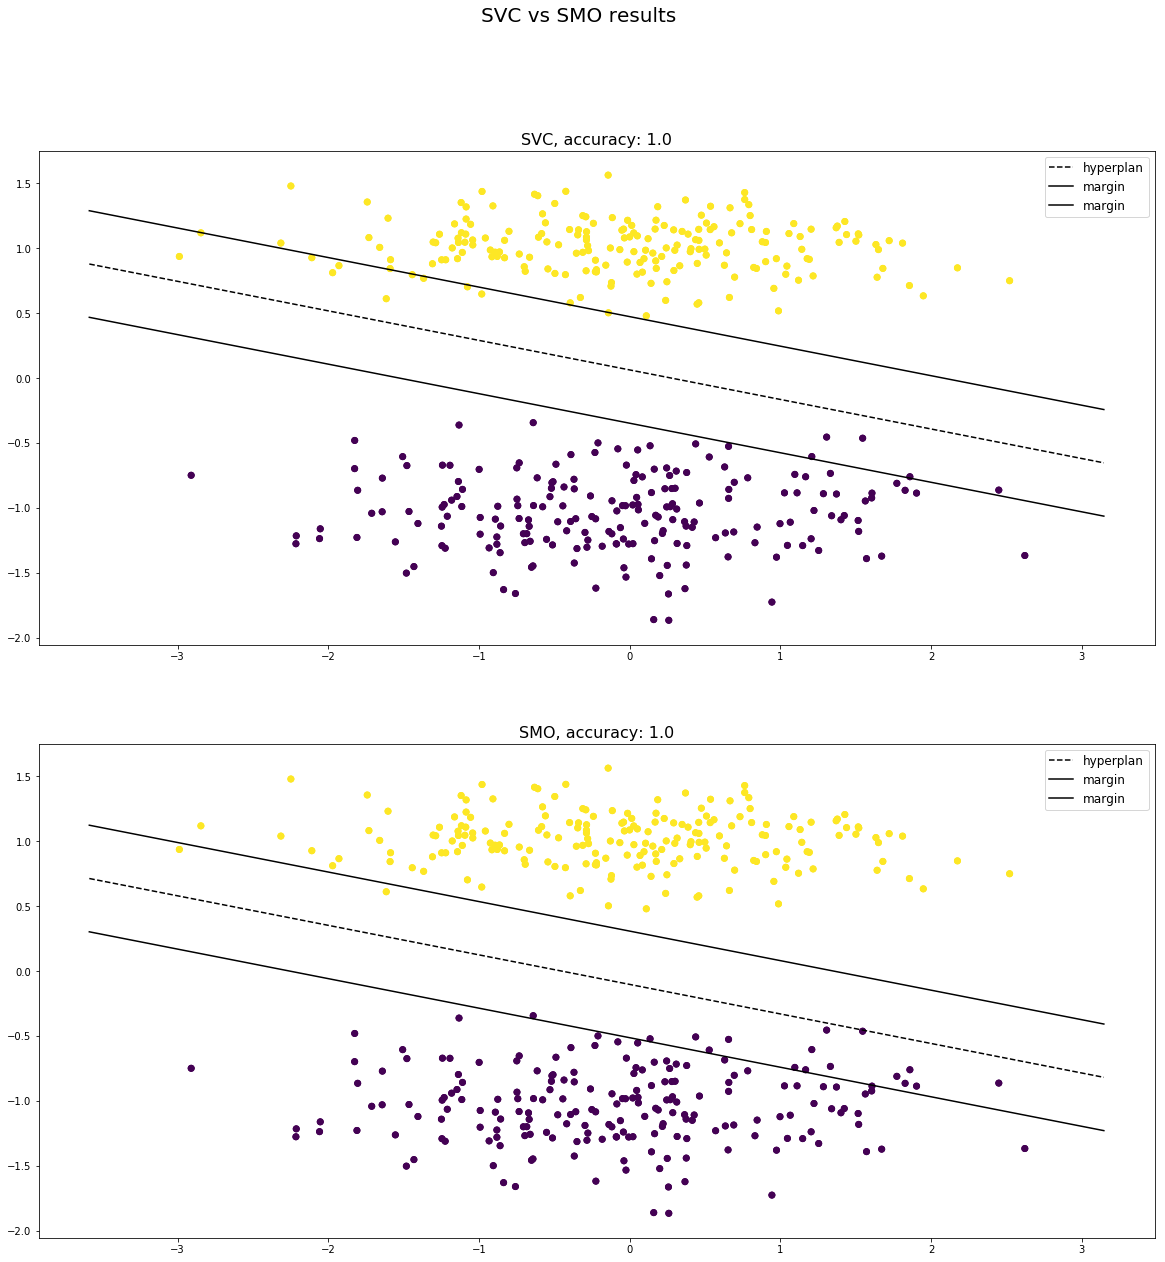

In [412]:
compareSVC_SMO()

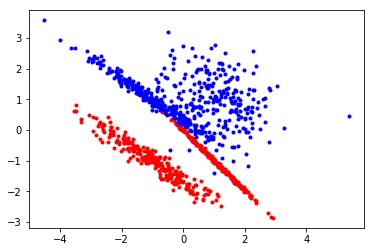

accuracy train for SVC:	0.973
accuracy test for SVC:	0.973
accuracy train for SMO:	0.975
accuracy test for SMO:	0.975


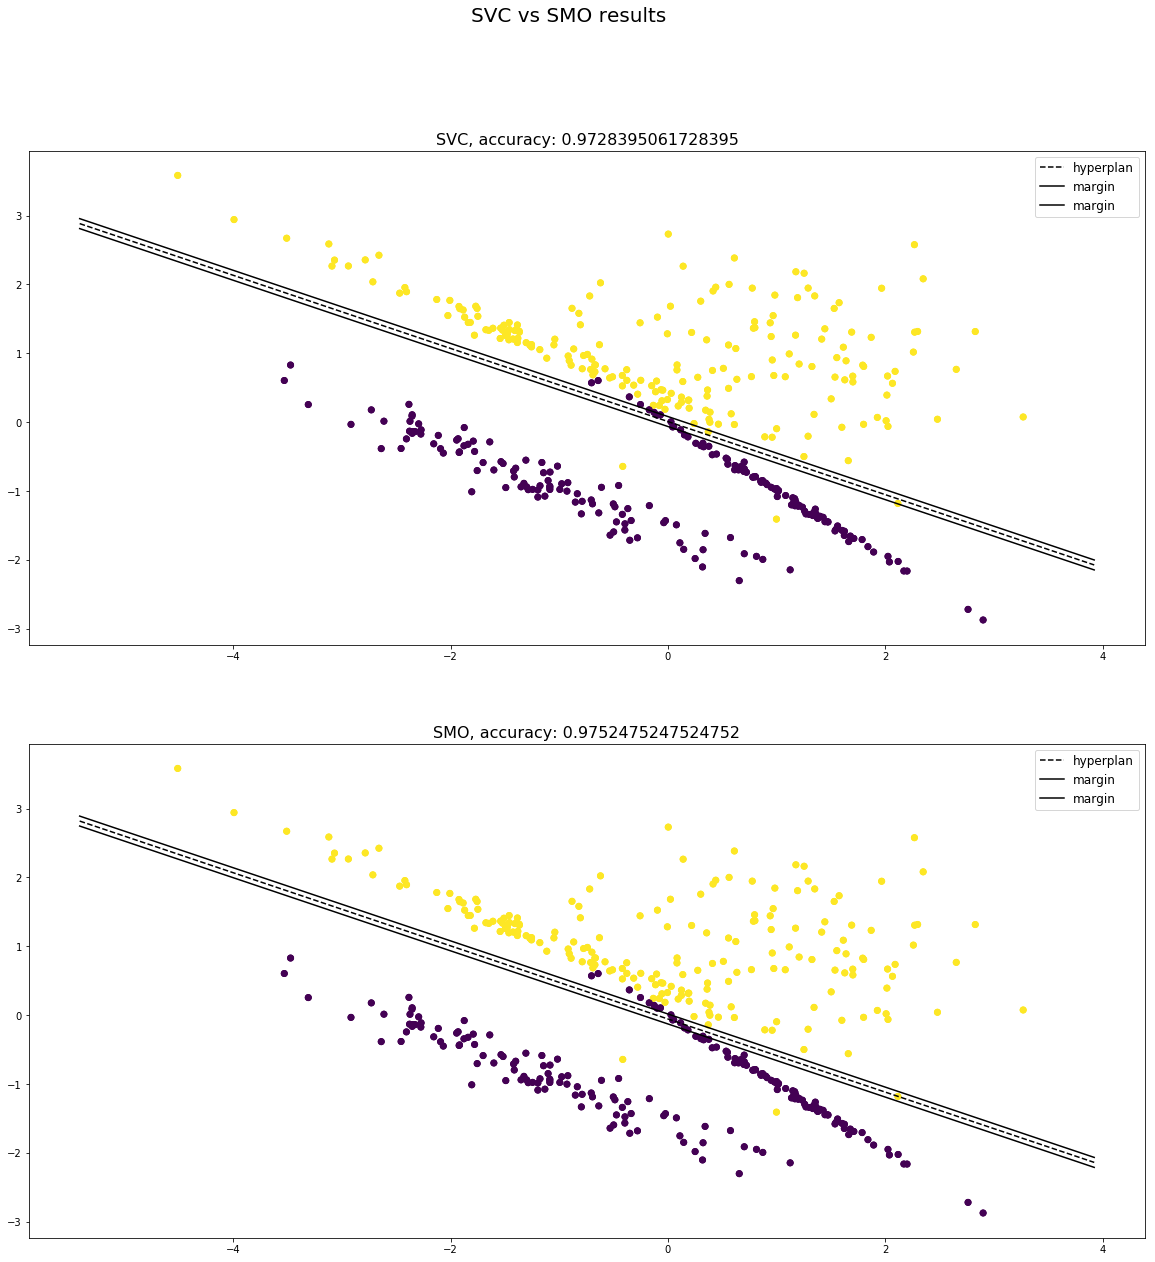

In [372]:
compareSVC_SMO(False)